In [2]:
import pyspark
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql import SparkSession
import os
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import os

directories = [
    "/Users/evangelosgeraridis/Desktop/MEAZON/September 2022",
    "/Users/evangelosgeraridis/Desktop/MEAZON/October 2022"
]

options = {
    "header": "true",
    "sep": ",",
    "multiLine": "true",
    "quote": "\"",
    "escape": "\"",
    "ignoreTrailingWhiteSpace": True
}

dataframes = {}

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Spark_LinearRegression_Meazon.com") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()


import logging
spark.sparkContext.setLogLevel("ERROR")
logging.getLogger("py4j").setLevel(logging.ERROR)


for directory in directories:
    files = os.listdir(directory)
    for file in files:
        if file != ".DS_Store":  # Exclude .DS_Store files
            file_path = os.path.join(directory, file)
            df = spark.read.options(**options).csv(file_path)
            dataframes[file] = df
            
            

from functools import reduce  
from pyspark.sql import DataFrame
fridge_data = DataFrame.union(dataframes['fridgeS.csv'], dataframes['fridgeO.csv'])
aggregated_data = DataFrame.union(dataframes['AggregatedS.csv'] , dataframes['AggregatedO.csv'])
dishwasher_data = DataFrame.union(dataframes['dishwasherS.csv'], dataframes['dishwasherO.csv'])
hotplate_data = DataFrame.union(dataframes['hotplateS.csv'], dataframes['hotplateO.csv'])
microwave_data = DataFrame.union(dataframes['microwaveS.csv'], dataframes['microwaveO.csv'])
washing_machine_data = DataFrame.union(dataframes['washing_machineS.csv'] , dataframes['washing_machineO.csv'])
water_heater_data = DataFrame.union(dataframes['water_heaterS.csv'], dataframes['water_heaterO.csv'])
data_list = [fridge_data, dishwasher_data, hotplate_data, microwave_data, washing_machine_data, water_heater_data]

for i in range(len(data_list)):
    data_list[i] = aggregated_data.join(data_list[i], on='ts')
    data_list[i] = data_list[i].drop('ts')
   
    
fridge_data  =  data_list[0].toDF('aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA', 'fridge_pwrA', 'fridge_apwrA', 'fridge_curA', 'fridge_vltA', 'fridge_screA')
dishwasher_data = data_list[1].toDF('aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA', 'dishwasher_pwrA', 'dishwasher_apwrA', 'dishwasher_curA', 'dishwasher_vltA', 'dishwasher_screA')
hotplate_data = data_list[2].toDF('aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA', 'hotplate_pwrA', 'hotplate_apwrA', 'hotplate_curA', 'hotplate_vltA', 'hotplate_screA')
microwave_data = data_list[3].toDF('aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA', 'microwave_pwrA', 'microwave_apwrA', 'microwave_curA', 'microwave_vltA', 'microwave_screA')
washing_machine_data = data_list[4].toDF('aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA', 'washing_machine_pwrA', 'washing_machine_apwrA', 'washing_machine_curA', 'washing_machine_vltA', 'washing_machine_screA')
water_heater_data = data_list[5].toDF('aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA', 'water_heater_pwrA', 'water_heater_apwrA', 'water_heater_curA', 'water_heater_vltA', 'water_heater_screA')

dataframes = [fridge_data, dishwasher_data, hotplate_data, microwave_data, washing_machine_data, water_heater_data]
modified_dataframes = []

for df in dataframes:
    for column in df.columns:
        df = df.withColumn(column, col(column).cast(DoubleType()))

    # Append the modified dataframe to the new list
    modified_dataframes.append(df)

# Assign the modified dataframes back to individual variables
fridge_data, dishwasher_data, hotplate_data, microwave_data, washing_machine_data, water_heater_data = modified_dataframes


for df in modified_dataframes:
    df = df.dropna()
    df.show(20)
    df.printSchema()
        
            

+---------------+----------------+---------------+---------------+----------------+-----------+------------+-----------+-----------+------------+
|aggregated_pwrA|aggregated_apwrA|aggregated_curA|aggregated_vltA|aggregated_screA|fridge_pwrA|fridge_apwrA|fridge_curA|fridge_vltA|fridge_screA|
+---------------+----------------+---------------+---------------+----------------+-----------+------------+-----------+-----------+------------+
|         33.136|          66.092|          0.297|        222.295|           1.666|     15.001|      15.128|      0.068|     222.37|       1.005|
|         34.121|          66.943|          0.299|        223.819|             1.6|     15.445|      15.418|      0.069|      223.9|       0.685|
|         33.852|          67.077|            0.3|        223.728|           1.709|     14.942|      15.055|      0.067|    223.836|       0.712|
|         33.807|          67.122|            0.3|        223.733|           1.526|     14.883|      15.035|      0.067|    

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Create dictionaries to hold the input and output column names for each device
input_cols = {
    'fridge': ['aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA'],
    'dishwasher': ['aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA'],
    'hotplate': ['aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA'],
    'microwave': ['aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA'],
    'washing_machine': ['aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA'],
    'water_heater': ['aggregated_pwrA', 'aggregated_apwrA', 'aggregated_curA', 'aggregated_vltA', 'aggregated_screA']
}

output_cols = {
    'fridge': ['fridge_pwrA', 'fridge_apwrA', 'fridge_curA', 'fridge_vltA', 'fridge_screA'],
    'dishwasher': ['dishwasher_pwrA', 'dishwasher_apwrA', 'dishwasher_curA', 'dishwasher_vltA', 'dishwasher_screA'],
    'hotplate': ['hotplate_pwrA', 'hotplate_apwrA', 'hotplate_curA', 'hotplate_vltA', 'hotplate_screA'],
    'microwave': ['microwave_pwrA', 'microwave_apwrA', 'microwave_curA', 'microwave_vltA', 'microwave_screA'],
    'washing_machine': ['washing_machine_pwrA', 'washing_machine_apwrA', 'washing_machine_curA', 'washing_machine_vltA', 'washing_machine_screA'],
    'water_heater': ['water_heater_pwrA', 'water_heater_apwrA', 'water_heater_curA', 'water_heater_vltA', 'water_heater_screA']
}

pipeline_models = {}
predictions = {}


# Iterate over the devices
for device in input_cols:
    # Get the input and output column names for the current device
    input_cols_device = input_cols[device]
    output_cols_device = output_cols[device]

    # Get the DataFrame for the current device
    df = globals()[device + '_data']

    # Split the dataset into train and test sets
    train_ratio = 0.8
    train_df, test_df = df.randomSplit([train_ratio, 1 - train_ratio], seed=42)

    for i in range(len(output_cols_device)):
        # Create vector assembler for input columns
        assembler = VectorAssembler(inputCols=input_cols_device, outputCol='features')

        # Create scaler
        scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

        # Create RandomForestRegressor
        lr = LinearRegression(featuresCol='scaled_features', labelCol=output_cols_device[i], maxIter=100, regParam= 0.1)

        # Create pipeline
        pipeline = Pipeline(stages=[assembler, scaler, lr])

        # Fit pipeline on the train set
        pipeline_model = pipeline.fit(train_df)

        # Make predictions on the test set
        predictions_device = pipeline_model.transform(test_df)

        # Add pipeline model and predictions to dictionaries
        pipeline_models[device + '_' + str(i)] = pipeline_model
        predictions[device + '_' + str(i)] = predictions_device

        # Evaluate the model on the predicted column
        evaluator = RegressionEvaluator(labelCol=output_cols_device[i], predictionCol='prediction', metricName='rmse')
        rmse = evaluator.evaluate(predictions_device)
        mse = evaluator.evaluate(predictions_device, {evaluator.metricName: 'mse'})
        mae = evaluator.evaluate(predictions_device, {evaluator.metricName: 'mae'})
        r2 = evaluator.evaluate(predictions_device, {evaluator.metricName: 'r2'})
        
        # Print the evaluation metrics
        print(f"Metrics for {output_cols_device[i]}:")
        print("RMSE:", rmse)
        print("MSE:", mse)
        print("MAE:", mae)
        print("R2:", r2)
        print()


Metrics for fridge_pwrA:
RMSE: 319.53613578072486
MSE: 102103.34206967785
MAE: 243.17054828297987
R2: 0.2980619087277486

Metrics for fridge_apwrA:
RMSE: 363.402971865162
MSE: 132061.7199604317
MAE: 277.5705676910999
R2: 0.27966810746809256

Metrics for fridge_curA:
RMSE: 1.8667130772950404
MSE: 3.484617712944319
MAE: 1.47510805492134
R2: 0.07338598966374876

Metrics for fridge_vltA:
RMSE: 0.39411281093706246
MSE: 0.15532490774471275
MAE: 0.30836565150647816
R2: 0.9698716970597655

Metrics for fridge_screA:
RMSE: 0.19210283127056793
MSE: 0.036903497782168296
MAE: 0.09374429019832918
R2: 0.017717549390698584

Metrics for dishwasher_pwrA:
RMSE: 93.74274280561077
MSE: 8787.701828718891
MAE: 50.847361377518695
R2: 0.2606060924313668

Metrics for dishwasher_apwrA:
RMSE: 510.56176171548503
MSE: 260673.31252601973
MAE: 268.5927432110137
R2: -0.07017495205265734

Metrics for dishwasher_curA:
RMSE: 2.2574427163172768
MSE: 5.096047617453925
MAE: 1.1654556897285284
R2: -0.10355404910876298

Metri

Metrics for water_heater_pwrA:
RMSE: 372.2234189939556
MSE: 138550.27364754982
MAE: 179.9576733475847
R2: 0.5133872551044635



Metrics for water_heater_apwrA:
RMSE: 372.21305245556397
MSE: 138542.5564182884
MAE: 180.76826378042946
R2: 0.5129924219154232



Metrics for water_heater_curA:
RMSE: 1.7534524842683479
MSE: 3.074595614586841
MAE: 0.8540560656199876
R2: 0.47940868790563906



Metrics for water_heater_vltA:
RMSE: 0.10391193836940002
MSE: 0.01079769093568599
MAE: 0.08293190553551227
R2: 0.9981803672326951



Metrics for water_heater_screA:
RMSE: 0.4941856893253473
MSE: 0.24421949553396868
MAE: 0.39099996467912
R2: 0.04212798365674231



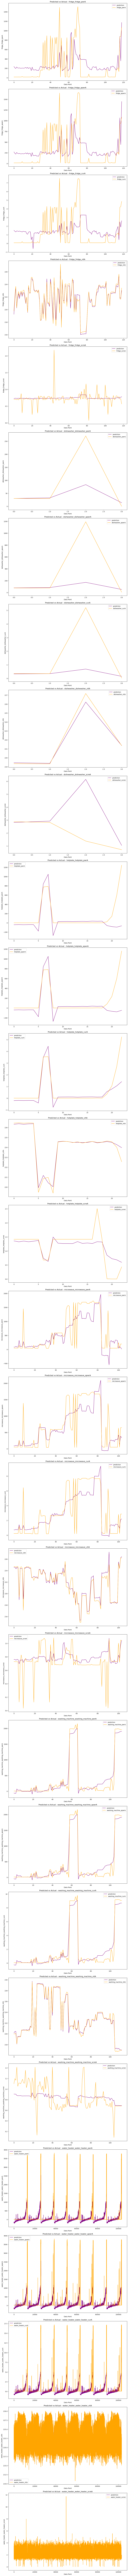

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary to hold the predicted and actual values for each model
preds_actual_dict = {}

# Iterate over the models
for device, cols in output_cols.items():
    for i in range(len(cols)):
        # Get the predicted and actual values for the current model
        predictions_device = predictions[device + '_' + str(i)]
        preds = predictions_device.select('prediction').toPandas()
        actual_values = predictions_device.select(cols[i]).toPandas()

        # Add the predicted and actual values to the dictionary
        preds_actual_dict[device + '_' + cols[i]] = (preds, actual_values)

# Create subplots for all the models
fig, axes = plt.subplots(len(preds_actual_dict), 1, figsize=(12, 8 * len(preds_actual_dict)))

# Iterate over the dictionary and plot the test values vs predicted values for each model
for i, (model_name, (preds, actual_values)) in enumerate(preds_actual_dict.items()):
    ax = axes[i] if len(preds_actual_dict) > 1 else axes

    # Plot predicted values
    preds.plot(ax=ax, label='Predicted', color = 'purple')

    # Plot actual values
    actual_values.plot(ax=ax, label='Actual', color = 'orange')

    # Set the plot labels
    ax.set_xlabel('Data Point')
    ax.set_ylabel(model_name)
    ax.set_title('Predicted vs Actual - ' + model_name)
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
